In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import plot_periodogram, seasonal_plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import calendar
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

from statsmodels.tsa.deterministic import CalendarFourier, CalendarSeasonality, CalendarTimeTrend, DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

In [3]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

In [4]:
sdate = '2015-08-15'
edate = '2017-08-15'

In [5]:
train_data = pd.read_csv(comp_dir / 'train.csv')
train_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
store_sales = pd.read_csv(comp_dir / 'train.csv',
                       usecols=['date', 'store_nbr', 'family', 'sales','onpromotion'],
                       dtype={'store_nbr': 'category', 'family': 'category', 'sales': 'float32', 'onpromotion': 'int32'},
                       parse_dates=['date'],
                       infer_datetime_format=True
                      )
store_sales['date'] = store_sales.date.dt.to_period('D')

m_index = pd.MultiIndex.from_product([store_sales["store_nbr"].unique(),
                                      store_sales["family"].unique(),
                                      pd.date_range(start="2013-1-1", end="2017-8-15", freq="D").to_period('D')] # to get missing Christmas Days
                                     ,names=["store_nbr","family", "date"])
store_sales = store_sales.set_index(["store_nbr","family", "date"]).reindex(m_index, fill_value=0).sort_index()

store_sales = store_sales.unstack(['store_nbr', 'family']).fillna(0) # there are lots!
store_sales = store_sales.stack(['store_nbr', 'family'])
store_sales = store_sales[['sales','onpromotion']] # reorder columns to be in the expected order

store_sales

sales  onpromotion
date       store_nbr family                                              
2013-01-01 1         AUTOMOTIVE                     0.000000            0
                     BABY CARE                      0.000000            0
                     BEAUTY                         0.000000            0
                     BEVERAGES                      0.000000            0
                     BOOKS                          0.000000            0
...                                                      ...          ...
2017-08-15 9         POULTRY                      438.132996            0
                     PREPARED FOODS               154.552994            1
                     PRODUCE                     2419.729004          148
                     SCHOOL AND OFFICE SUPPLIES   121.000000            8
                     SEAFOOD                       16.000000            0

[3008016 rows x 2 columns]

In [7]:
CALENDAR = pd.DataFrame(pd.period_range(start='2013-01-01', end = '2017-08-31'),columns=['date'])
CALENDAR = CALENDAR.set_index(['date']).sort_index()

CALENDAR

""
date
2013-01-01
2013-01-02
2013-01-03
2013-01-04
2013-01-05
...
2017-08-27
2017-08-28
2017-08-29


In [8]:
## oil data

oil_data = pd.read_csv(comp_dir / 'oil.csv',
                      parse_dates =  ['date'],
                      infer_datetime_format = True,
                      dtype = {'dcoilwtico' : 'float32'}
                      )
oil_data['date'] = oil_data.date.dt.to_period('D')
oil_data = oil_data.set_index(['date']).sort_index()

oil_df = oil_data.copy()
oil_df

,dcoilwtico
date,
2013-01-01,NaN
2013-01-02,93.139999
2013-01-03,92.970001
2013-01-04,93.120003
2013-01-07,93.199997
...,...
2017-08-25,47.650002
2017-08-28,46.400002
2017-08-29,46.459999


In [9]:
oil_df['dcoilwtico']  = oil_df['dcoilwtico'].interpolate(limit_direction='both')
oil_df["oil_ma"] = oil_df['dcoilwtico'].rolling(window=7).mean()
oil_df["oil_sd"] = oil_df['dcoilwtico'].rolling(window=7).std()

oil_df

,dcoilwtico,oil_ma,oil_sd
date,,,
2013-01-01,93.139999,NaN,NaN
2013-01-02,93.139999,NaN,NaN
2013-01-03,92.970001,NaN,NaN
2013-01-04,93.120003,NaN,NaN
2013-01-07,93.199997,NaN,NaN
...,...,...,...
2017-08-25,47.650002,47.720001,0.586146
2017-08-28,46.400002,47.624287,0.743547
2017-08-29,46.459999,47.320001,0.717867


<AxesSubplot:title={'center':'Moving Average oil'}, xlabel='date'>

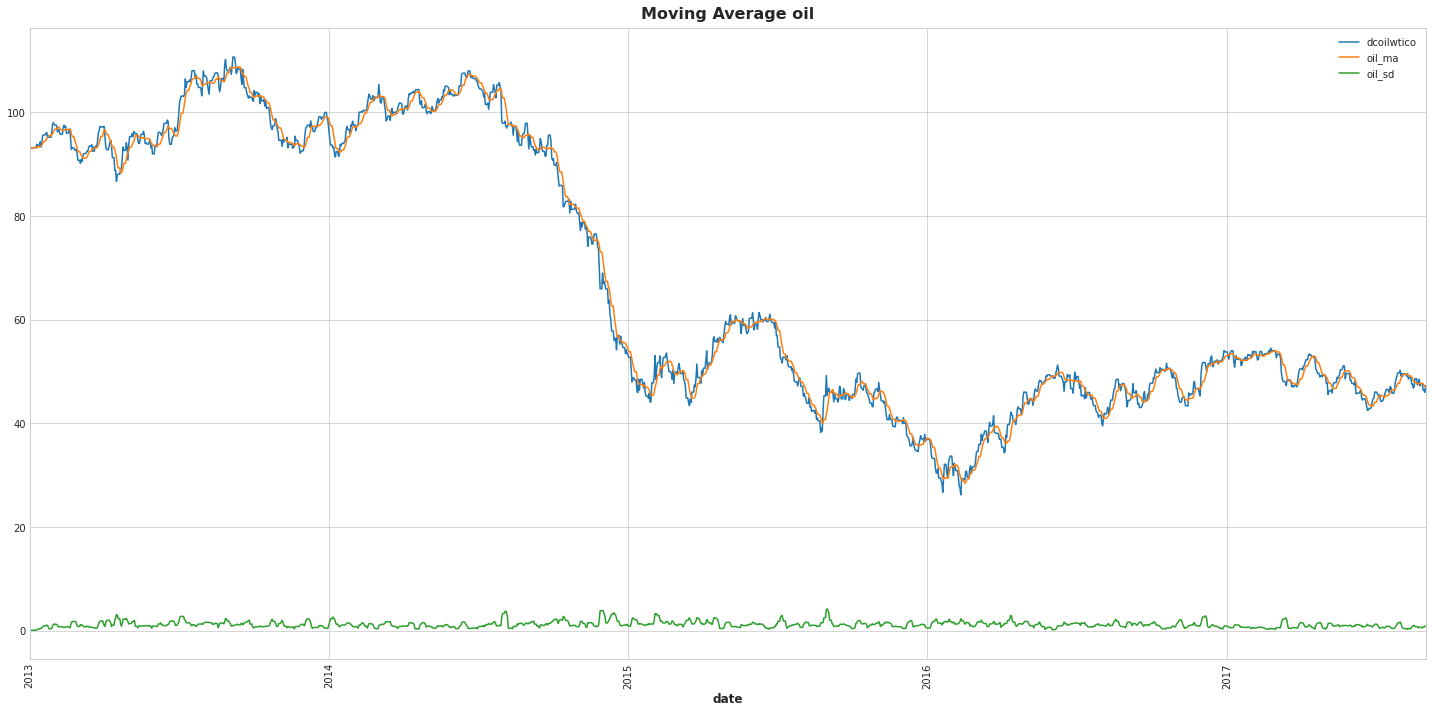

In [10]:
CALENDAR = CALENDAR.join(oil_df, on = 'date')
CALENDAR.ffill(inplace=True)
CALENDAR.bfill(inplace=True)

CALENDAR.plot(figsize=(20,10), title= "Moving Average oil", xlabel= "date", rot=90)

In [11]:
CALENDAR['dofw'] = CALENDAR.index.dayofweek
CALENDAR['wage_day'] = (CALENDAR.index.day == CALENDAR.index.daysinmonth) | (CALENDAR.index.day == 15).astype(int) 

CALENDAR

,dcoilwtico,oil_ma,oil_sd,dofw,wage_day
date,,,,,
2013-01-01,93.139999,93.122857,0.080975,1,0
2013-01-02,93.139999,93.122857,0.080975,2,0
2013-01-03,92.970001,93.122857,0.080975,3,0
2013-01-04,93.120003,93.122857,0.080975,4,0
2013-01-05,93.120003,93.122857,0.080975,5,0
...,...,...,...,...,...
2017-08-27,47.650002,47.720001,0.586146,6,0
2017-08-28,46.400002,47.624287,0.743547,0,0
2017-08-29,46.459999,47.320001,0.717867,1,0


#### Holiday dataset analysis

In [12]:
## Checking the Hoiliday dataset..

holiday_data = pd.read_csv(comp_dir / 'holidays_events.csv',
                           dtype={
                                  'type': 'category',
                                  'locale': 'category',
                                  'locale_name': 'category',
                                  'description': 'category',
                                  'transferred': 'bool'
                                 },
                          parse_dates=['date'],
                          infer_datetime_format=True)

holiday_data = holiday_data.set_index('date').to_period('D')

holiday_data.head()

,type,locale,locale_name,description,transferred
date,,,,,
2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [13]:
holiday_df = holiday_data.query("locale in ['National', 'Regional']")

## Remove duplicates from the 'holiday' dataset
holiday_df = holiday_df.groupby(holiday_df.index).first()

print(holiday_df.shape)
holiday_df

(191, 5)


,type,locale,locale_name,description,transferred
date,,,,,
2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2012-06-25,Holiday,Regional,Imbabura,Provincializacion de Imbabura,False
2012-08-10,Holiday,National,Ecuador,Primer Grito de Independencia,False
2012-10-09,Holiday,National,Ecuador,Independencia de Guayaquil,True
2012-10-12,Transfer,National,Ecuador,Traslado Independencia de Guayaquil,False
...,...,...,...,...,...
2017-12-22,Additional,National,Ecuador,Navidad-3,False
2017-12-23,Additional,National,Ecuador,Navidad-2,False
2017-12-24,Additional,National,Ecuador,Navidad-1,False


In [14]:
CALENDAR['WD'] = 1
CALENDAR.loc[CALENDAR.dofw > 4, 'WD'] = 0

CALENDAR = CALENDAR.merge(holiday_df, on='date', how='left')


CALENDAR.loc[CALENDAR.type == 'Bridge'  , 'WD'] = 0
CALENDAR.loc[CALENDAR.type == 'Work Day', 'WD'] = 1
CALENDAR.loc[CALENDAR.type == 'Transfer', 'WD'] = 0
CALENDAR.loc[(CALENDAR.type == 'Holiday') & (CALENDAR.transferred == False), 'WD'] = 0
CALENDAR.loc[(CALENDAR.type == 'Holiday') & (CALENDAR.transferred == True ), 'WD'] = 1

CALENDAR = pd.get_dummies(CALENDAR, columns = ['dofw'], drop_first = True) 
CALENDAR = pd.get_dummies(CALENDAR, columns = ['type'])

CALENDAR.drop(['locale', 'locale_name', 'description', 'transferred'], axis=1, inplace=True)

CALENDAR

,dcoilwtico,oil_ma,oil_sd,wage_day,WD,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
date,,,,,,,,,,,,,,,,,
2013-01-01,93.139999,93.122857,0.080975,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2013-01-02,93.139999,93.122857,0.080975,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-03,92.970001,93.122857,0.080975,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-04,93.120003,93.122857,0.080975,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2013-01-05,93.120003,93.122857,0.080975,0,1,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.650002,47.720001,0.586146,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-08-28,46.400002,47.624287,0.743547,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2017-08-29,46.459999,47.320001,0.717867,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [15]:
CALENDAR.columns

Index(['dcoilwtico', 'oil_ma', 'oil_sd', 'wage_day', 'WD', 'dofw_1', 'dofw_2',
       'dofw_3', 'dofw_4', 'dofw_5', 'dofw_6', 'type_Additional',
       'type_Bridge', 'type_Event', 'type_Holiday', 'type_Transfer',
       'type_Work Day'],
      dtype='object')

In [16]:
keep_cols = ['oil_ma', 'oil_sd', 'wage_day', 'WD', 'dofw_1', 'dofw_2', 'dofw_3', 'dofw_4', 'dofw_5',
             'dofw_6', 'type_Additional', 'type_Bridge', 'type_Event', 'type_Holiday', 'type_Transfer', 'type_Work Day'
             ]

CALENDAR = CALENDAR[keep_cols]
CALENDAR

,oil_ma,oil_sd,wage_day,WD,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
date,,,,,,,,,,,,,,,,
2013-01-01,93.122857,0.080975,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2013-01-02,93.122857,0.080975,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2013-01-03,93.122857,0.080975,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2013-01-04,93.122857,0.080975,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2013-01-05,93.122857,0.080975,0,1,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-27,47.720001,0.586146,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-08-28,47.624287,0.743547,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2017-08-29,47.320001,0.717867,0,1,1,0,0,0,0,0,0,0,0,0,0,0


In [17]:
CALENDAR_train = CALENDAR.loc[sdate:edate]

X_time = CALENDAR_train.copy()

X_time

,oil_ma,oil_sd,wage_day,WD,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
date,,,,,,,,,,,,,,,,
2015-08-15,43.507143,1.038599,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2015-08-16,43.507143,1.038599,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2015-08-17,43.112857,1.038600,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2015-08-18,42.928572,0.995413,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2015-08-19,42.330001,0.830402,0,1,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,49.140000,0.392895,0,0,0,0,0,1,0,0,0,0,0,0,1,0
2017-08-12,49.140000,0.392895,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2017-08-13,49.140000,0.392895,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [18]:
y = store_sales.unstack(['store_nbr', 'family']).loc[sdate:edate,'sales']
y

store_nbr           1                                                \
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2015-08-15        3.0       0.0    0.0    2845.0   0.0   448.640991   
2015-08-16        1.0       0.0    2.0     813.0   0.0   138.257996   
2015-08-17        0.0       0.0    2.0    2194.0   0.0   408.356995   
2015-08-18       10.0       0.0    2.0    2111.0   0.0   383.898987   
2015-08-19        4.0       0.0    1.0    2001.0   0.0   386.796997   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

store_nbr                                           ...         9              \
family     CELEBRATION CLEANING  DAIRY        DELI  ... MAGAZINES       MEATS   
date                                                ...                         
2015-08-15        17.0    700.0  733.0  127.873001  ...       0.0  409.487000   
2015-08-16         2.0    260.0  264.0   53.129002  ...       2.0  433.927002   
2015-08-17         9.0    673.0  735.0  188.171997  ...       0.0  464.451996   
2015-08-18        18.0    633.0  759.0  133.858994  ...       0.0  312.511993   
2015-08-19        14.0    711.0  765.0  158.001007  ...       1.0  390.575012   
...                ...      ...    ...         ...  ...       ...         ...   
2017-08-11         4.0    341.0  343.0   64.302002  ...       5.0  309.244995   
2017-08-12         3.0    351.0  526.0   99.487999  ...       2.0  260.298004   
2017-08-13         1.0    169.0  266.0   47.770000  ...       3.0  327.205994   
2017-08-14         4.0    571.0  699.0  154.578003  ...      12.0  330.975006   
2017-08-15        21.0    703.0  602.0  116.402000  ...      11.0  449.227997   

store_nbr                                                                  \
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS     POULTRY   
date                                                                        
2015-08-15         611.0          6.0                    17.0  620.854004   
2015-08-16         619.0          8.0                    22.0  653.322998   
2015-08-17         512.0          1.0                     9.0  489.923004   
2015-08-18         472.0          6.0                     9.0  362.820007   
2015-08-19         400.0          5.0                    12.0  360.196991   
...                  ...          ...                     ...         ...   
2017-08-11         373.0         11.0                     2.0  525.223999   
2017-08-12         400.0          7.0                    10.0  383.386993   
2017-08-13         510.0          2.0                     9.0  412.458008   
2017-08-14         445.0          2.0                    14.0  283.428986   
2017-08-15         522.0          6.0                     6.0  438.132996   

store_nbr                                                                     
family     PREPARED FOODS      PRODUCE SCHOOL AND OFFICE SUPPLIES    SEAFOOD  
date                                                                          
2015-08-15      94.003998  1685.043945                       12.0  18.028999  
2015-08-16     100.000000  2078.707031                        6.0  25.507000  
2015-08-17      99.767998  1460.939941                        6.0  27.507000  
2015-08-18      77.227997  2126.814941                        9.0  13.026000  
2015-08-19      62.000000  1270.354980                        7.0  17.124001  
...                   ...          ...                        ...        ...  
2017-08-11     112.099998  1453.078003                      140.0  23.830999  
2

In [19]:
index = y.index
tt = CalendarTimeTrend("D", True, order=2)
four_M = CalendarFourier("M", 12)
four_A = CalendarFourier("A", 4)
seas = CalendarSeasonality("D", "W")
det_proc = DeterministicProcess(index, additional_terms=[tt, seas, four_M, four_A], drop=True)
X_dp = det_proc.in_sample()

X_dp

,const,trend,trend_squared,"s(D=2, period=W)","s(D=3, period=W)","s(D=4, period=W)","s(D=5, period=W)","s(D=6, period=W)","s(D=7, period=W)","sin(1,freq=M)",...,"sin(12,freq=M)","cos(12,freq=M)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)"
date,,,,,,,,,,,,,,,,,,,,,
2015-08-15,1.0,16663.0,277655569.0,0.0,0.0,0.0,0.0,1.0,0.0,0.299363,...,0.485302,-0.874347,-0.680773,-0.732494,0.997325,0.073095,-0.780296,0.625411,0.145799,-0.989314
2015-08-16,1.0,16664.0,277688896.0,0.0,0.0,0.0,0.0,0.0,1.0,0.101168,...,-0.937752,0.347305,-0.693281,-0.720667,0.999250,0.038722,-0.746972,0.664855,0.077386,-0.997001
2015-08-17,1.0,16665.0,277722225.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.101168,...,0.937752,0.347305,-0.705584,-0.708627,0.999991,0.004304,-0.711657,0.702527,0.008607,-0.999963
2015-08-18,1.0,16666.0,277755556.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.299363,...,-0.485302,-0.874347,-0.717677,-0.696376,0.999546,-0.030120,-0.674444,0.738326,-0.060213,-0.998186
2015-08-19,1.0,16667.0,277788889.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.485302,...,-0.201299,0.979530,-0.729558,-0.683919,0.997917,-0.064508,-0.635432,0.772157,-0.128748,-0.991677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,17390.0,302412100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.897805,...,-0.724793,0.688967,-0.628763,-0.777597,0.977848,0.209315,-0.891981,0.452072,0.409356,-0.912375
2017-08-12,1.0,17391.0,302446881.0,0.0,0.0,0.0,0.0,1.0,0.0,0.790776,...,0.998717,-0.050649,-0.642055,-0.766659,0.984474,0.175531,-0.867456,0.497513,0.345612,-0.938377
2017-08-13,1.0,17392.0,302481664.0,0.0,0.0,0.0,0.0,0.0,1.0,0.651372,...,-0.790776,-0.612106,-0.655156,-0.755493,0.989932,0.141540,-0.840618,0.541628,0.280231,-0.959933


In [20]:
X1 = pd.concat([X_dp, X_time], axis=1).fillna(0.0)
X1

,const,trend,trend_squared,"s(D=2, period=W)","s(D=3, period=W)","s(D=4, period=W)","s(D=5, period=W)","s(D=6, period=W)","s(D=7, period=W)","sin(1,freq=M)",...,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
date,,,,,,,,,,,,,,,,,,,,,
2015-08-15,1.0,16663.0,277655569.0,0.0,0.0,0.0,0.0,1.0,0.0,0.299363,...,0,0,1,0,0,0,0,0,0,0
2015-08-16,1.0,16664.0,277688896.0,0.0,0.0,0.0,0.0,0.0,1.0,0.101168,...,0,0,0,1,0,0,0,0,0,0
2015-08-17,1.0,16665.0,277722225.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.101168,...,0,0,0,0,0,0,0,0,0,0
2015-08-18,1.0,16666.0,277755556.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.299363,...,0,0,0,0,0,0,0,0,0,0
2015-08-19,1.0,16667.0,277788889.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.485302,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,17390.0,302412100.0,0.0,0.0,0.0,1.0,0.0,0.0,0.897805,...,0,1,0,0,0,0,0,0,1,0
2017-08-12,1.0,17391.0,302446881.0,0.0,0.0,0.0,0.0,1.0,0.0,0.790776,...,0,0,1,0,0,0,0,0,0,0
2017-08-13,1.0,17392.0,302481664.0,0.0,0.0,0.0,0.0,0.0,1.0,0.651372,...,0,0,0,1,0,0,0,0,0,0


In [21]:
def encode_categoricals(df, columns):
    le = LabelEncoder()  # from sklearn.preprocessing
    for col in columns:
        df[col] = le.fit_transform(df[col])
    return df

In [22]:
def make_X2_lags(ts, lags, lead_time=1, name='y', stack_cols=None):
    ts = ts.unstack(stack_cols)
    df = pd.concat(
        {
            f'{name}_lag_{i}': ts.shift(i, freq="D") 
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)
    df = df.stack(stack_cols).reset_index()
    df = encode_categoricals(df, stack_cols)
    df = df.set_index('date').sort_values(by=stack_cols) # return sorted so can correctly compute rolling means (if desired)
    return df

In [23]:
def make_X2_features(df, y_resid):
    stack_columns = ['store_nbr', 'family']
    
    # promo_lag features
    shifted_promo_df = make_X2_lags(df.squeeze(), lags=2, name='promo', stack_cols=['store_nbr', 'family'])
    
    #y_lag features
    shifted_y_df = make_X2_lags(y_resid, lags=2, name='y_res', stack_cols=stack_columns)

    df = df.reset_index(stack_columns)
    X2 = encode_categoricals(df, stack_columns)
    
    X2["day_of_w"] = X2.index.dayofweek    
    
    X2['wage_day'] = (X2.index.day == X2.index.daysinmonth) | (X2.index.day == 15).astype(int)
    
    X2 = X2.merge(shifted_promo_df, on=['date', 'store_nbr', 'family'], how='left')
    X2 = X2.merge(shifted_y_df, on=['date', 'store_nbr', 'family'], how='left')    
    X2 = X2.fillna(0.0)
    
    
    return X2

In [24]:
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None
        self.stack_cols = None
        self.y_resid = None 
        
    def fit1(self, X_1, y, stack_cols=None):                  
        self.model_1.fit(X_1, y)
        y_fit = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index, columns=y.columns,
        )
        self.y_resid = y - y_fit
        self.y_resid_stacked = self.y_resid.stack(stack_cols).squeeze() # wide to long
        self.y_columns = y.columns # Save for predict method
        
        
    def fit2(self, X_2, stack_cols=None):
        self.model_2.fit(X_2, self.y_resid_stacked) # Train model_2
        self.stack_cols = stack_cols # Save for predict method
        
    
    def predict(self, X_1, X_2):
        y_pred = pd.DataFrame(
            self.model_1.predict(X_1),
            index=X_1.index,
            columns=self.y_columns,
        )
        y_pred = y_pred.stack(self.stack_cols).squeeze()  # wide to long
        y_pred += self.model_2.predict(X_2) # Add model_2 predictions to model_1 predictions
        return y_pred.unstack(self.stack_cols)        

In [25]:
store_sales_X2 = store_sales.unstack(['store_nbr', 'family']).loc[sdate:edate]
store_sales_X2

sales                                                \
store_nbr           1                                                 
family     AUTOMOTIVE BABY CARE BEAUTY BEVERAGES BOOKS BREAD/BAKERY   
date                                                                  
2015-08-15        3.0       0.0    0.0    2845.0   0.0   448.640991   
2015-08-16        1.0       0.0    2.0     813.0   0.0   138.257996   
2015-08-17        0.0       0.0    2.0    2194.0   0.0   408.356995   
2015-08-18       10.0       0.0    2.0    2111.0   0.0   383.898987   
2015-08-19        4.0       0.0    1.0    2001.0   0.0   386.796997   
...               ...       ...    ...       ...   ...          ...   
2017-08-11        1.0       0.0    1.0    1006.0   0.0   145.606995   
2017-08-12        6.0       0.0    3.0    1659.0   0.0   243.220001   
2017-08-13        1.0       0.0    1.0     803.0   0.0   136.679001   
2017-08-14        1.0       0.0    6.0    2201.0   0.0   346.037994   
2017-08-15        4.0       0.0    4.0    1942.0   0.0   329.541016   

                                                    ... onpromotion        \
store_nbr                                           ...           9         
family     CELEBRATION CLEANING  DAIRY        DELI  ...   MAGAZINES MEATS   
date                                                ...                     
2015-08-15        17.0    700.0  733.0  127.873001  ...           0     0   
2015-08-16         2.0    260.0  264.0   53.129002  ...           0     0   
2015-08-17         9.0    673.0  735.0  188.171997  ...           0     0   
2015-08-18        18.0    633.0  759.0  133.858994  ...           0     0   
2015-08-19        14.0    711.0  765.0  158.001007  ...           0     0   
...                ...      ...    ...         ...  ...         ...   ...   
2017-08-11         4.0    341.0  343.0   64.302002  ...           0     0   
2017-08-12         3.0    351.0  526.0   99.487999  ...           0     0   
2017-08-13         1.0    169.0  266.0   47.770000  ...           0     0   
2017-08-14         4.0    571.0  699.0  154.578003  ...           0     0   
2017-08-15        21.0    703.0  602.0  116.402000  ...           0     0   

                                                                       \
store_nbr                                                               
family     PERSONAL CARE PET SUPPLIES PLAYERS AND ELECTRONICS POULTRY   
date                                                                    
2015-08-15             0            0                       0       0   
2015-08-16             0            0                       0       2   
2015-08-17             0            0                       0       0   
2015-08-18             0            0                       0       0   
2015-08-19             0            0                       0       0   
...                  ...          ...                     ...     ...   
2017-08-11            11            0                       0      22   
2017-08-12             7            0                       0       0   
2017-08-13             9            0                       0       0   
2017-08-14            10            0                       0       0   
2017-08-15            11            0                       0       0   

                                                                      
store_nbr                                                             
family     PREPARED FOODS PRODUCE SCHOOL AND OFFICE SUPPLIES SEAFOOD  
date                                                                  
2015-08-15              0       0                          0       4  
2015-08-16              0       2                          0       0  
2015-08-17              0       0                          0       0  
2015-08-18              2     134                          0       0  
2015-08-19             12       1                          0       0  
...                   ...     ...                        ..

In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet


model = BoostedHybrid(model_1=ElasticNet(alpha=0.5, fit_intercept=False, random_state=42), model_2=RandomForestRegressor())

In [27]:
model.fit1(X1, y, stack_cols=['store_nbr', 'family'])

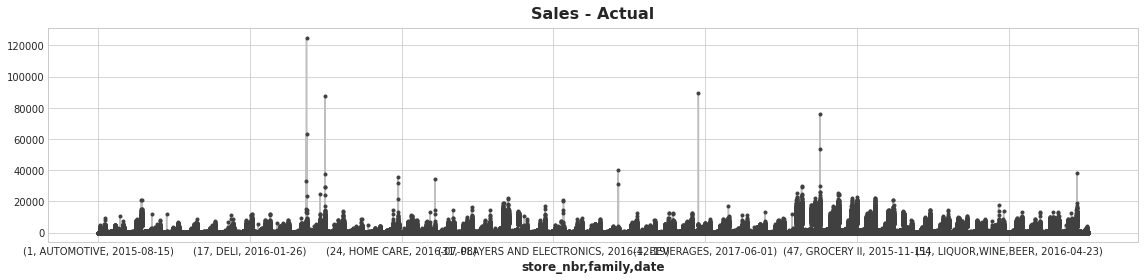

In [28]:
ax = y.unstack(level=0).plot(**plot_params, figsize=(16, 4))
ax.set_title('Sales - Actual');

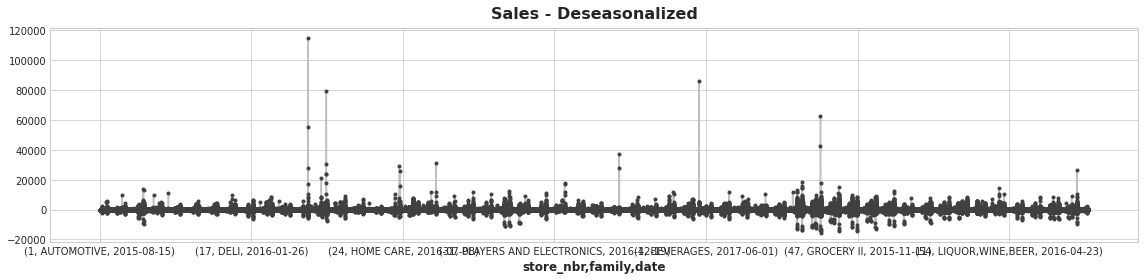

In [29]:
ax = model.y_resid.unstack(level=0).plot(**plot_params, figsize=(16, 4))
ax.set_title('Sales - Deseasonalized');

In [30]:
X2 = make_X2_features(store_sales_X2 # preparing X2 for hybrid model 2
                       .drop('sales', axis=1)
                       .stack(['store_nbr', 'family']),
                       model.y_resid_stacked)

X2

,store_nbr,family,onpromotion,day_of_w,wage_day,promo_lag_1,promo_lag_2,y_res_lag_1,y_res_lag_2
date,,,,,,,,,
2015-08-15,0,0,0,5,1,0.0,0.0,0.000000,0.000000
2015-08-15,0,1,0,5,1,0.0,0.0,0.000000,0.000000
2015-08-15,0,2,0,5,1,0.0,0.0,0.000000,0.000000
2015-08-15,0,3,5,5,1,0.0,0.0,0.000000,0.000000
2015-08-15,0,4,0,5,1,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
2017-08-15,53,28,0,1,1,0.0,0.0,-112.783893,-160.856719
2017-08-15,53,29,1,1,1,0.0,1.0,12.566922,-22.829869
2017-08-15,53,30,148,1,1,7.0,7.0,-101.992870,-212.630082


In [31]:
model.fit2(X2, stack_cols=['store_nbr', 'family'])

In [32]:
y_pred = model.predict(X1, X2).clip(0.0)

In [33]:
print("Model RMSE : ", mean_squared_log_error(y, y_pred)**0.5)

Model RMSE :  0.36097412576516524


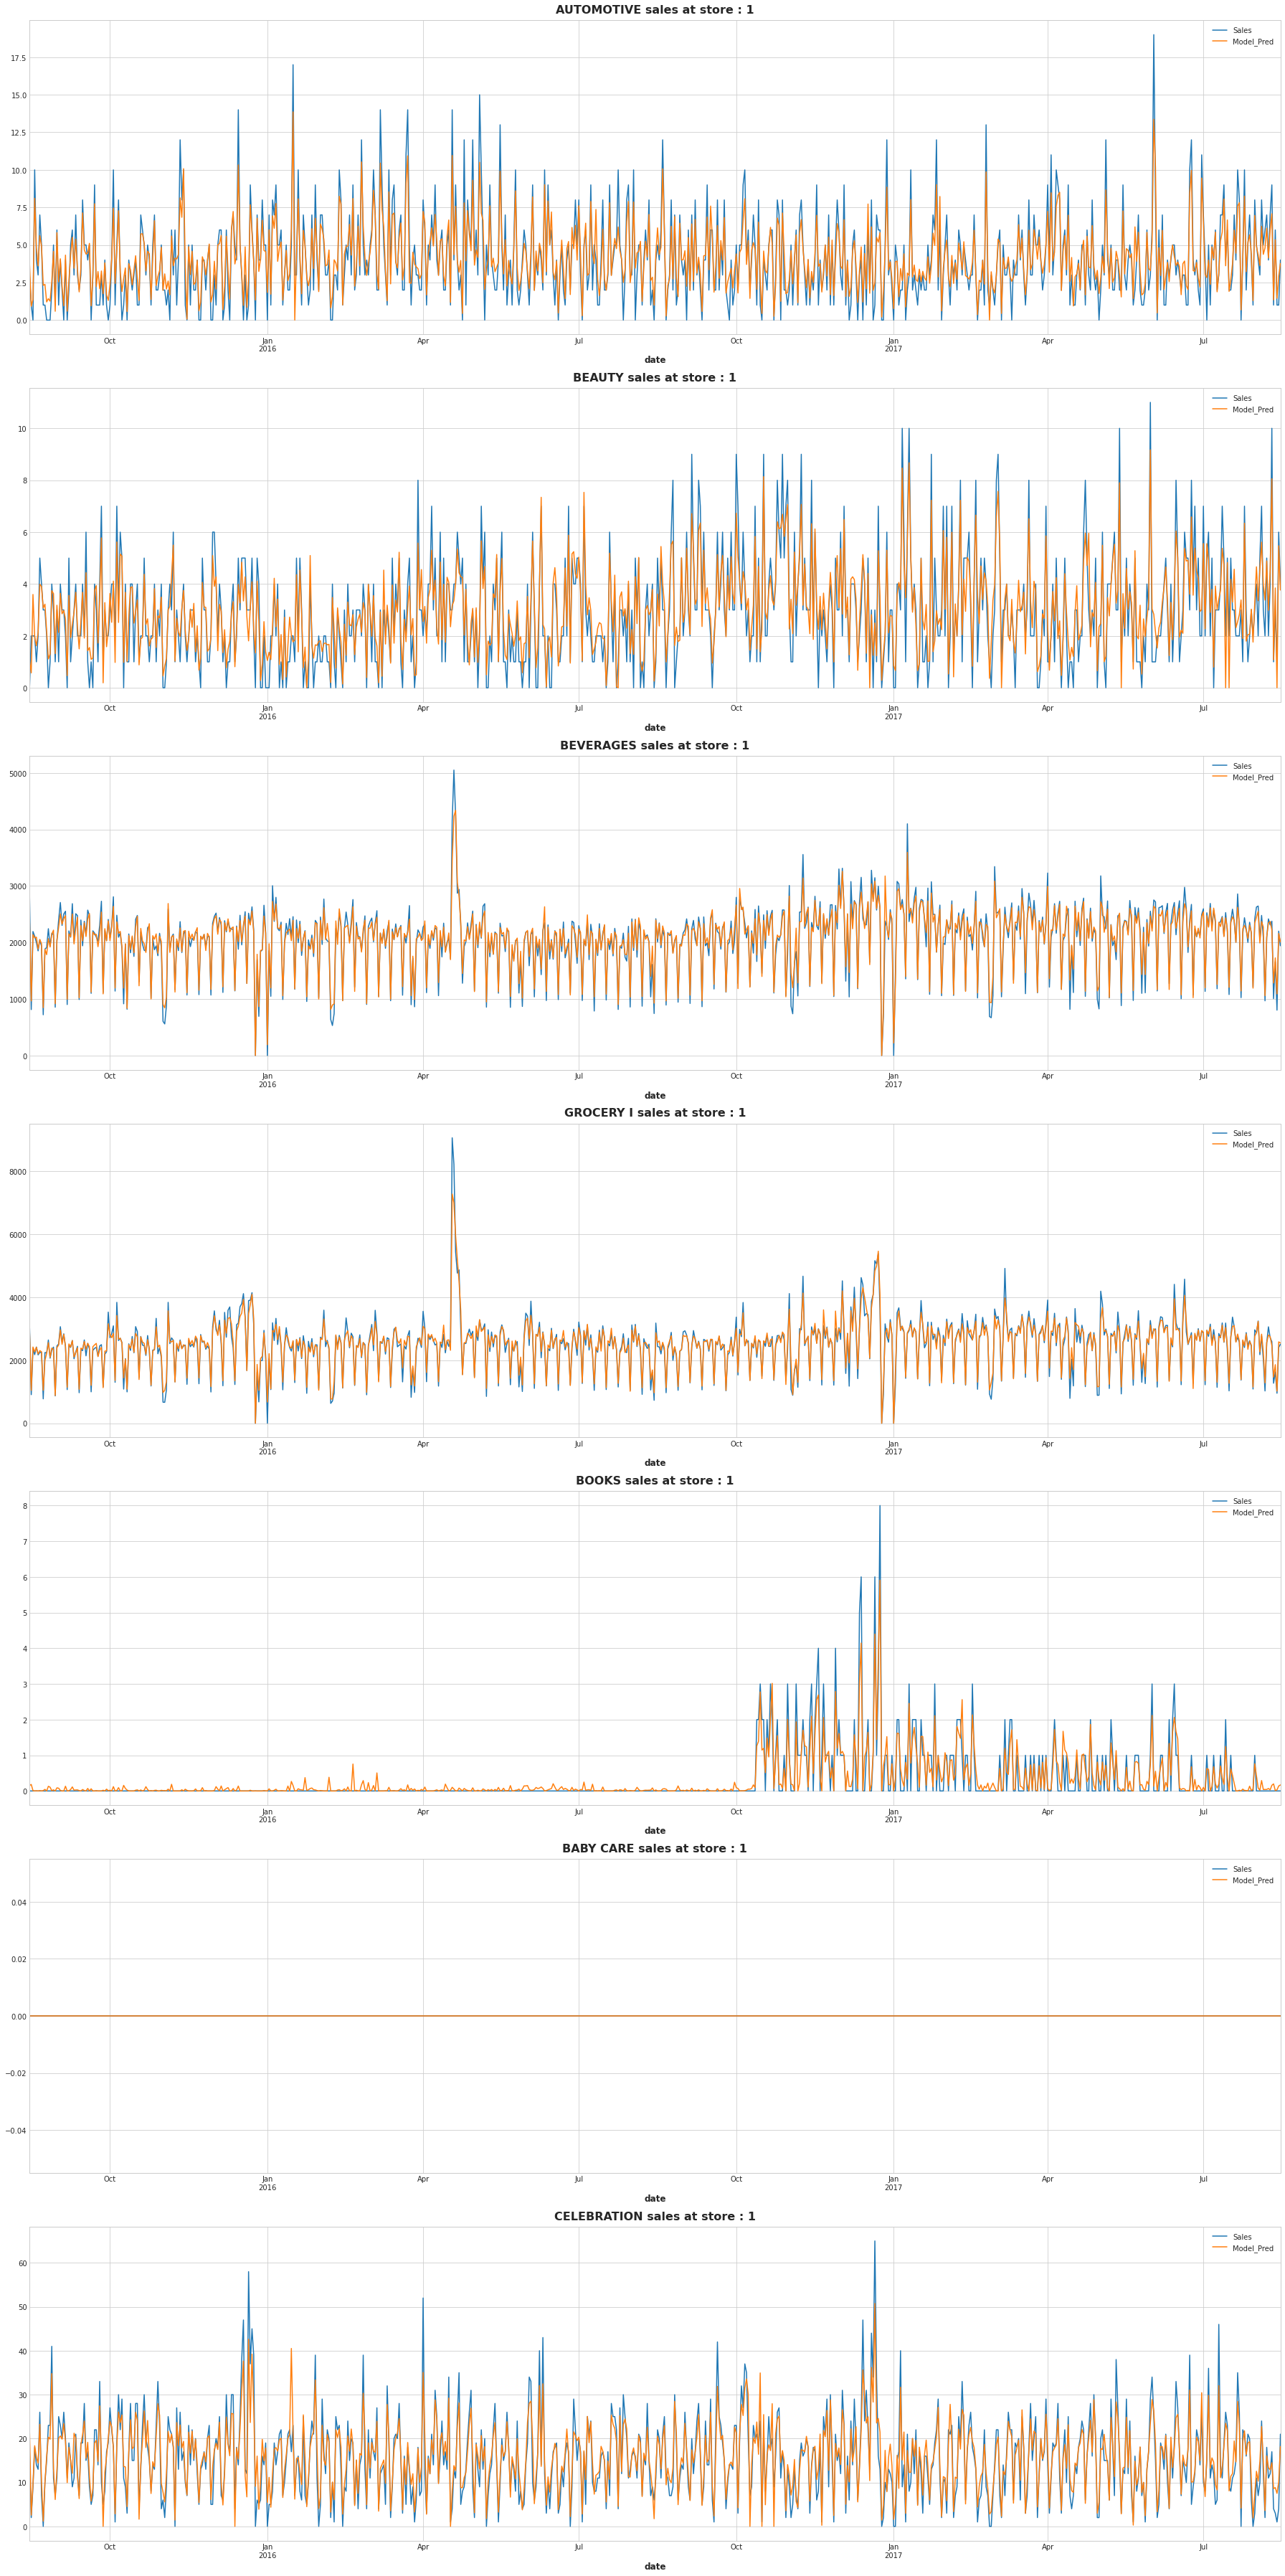

In [34]:
## plotting our predictions over Actual sales

families = ['AUTOMOTIVE','BEAUTY','BEVERAGES','GROCERY I', "BOOKS", "BABY CARE", "CELEBRATION"]
store_nbr = '1'

fig, axs = plt.subplots(len(families), figsize=(25,50))
for i in range(len(families)):
    axs[i] = y.loc(axis=1)[store_nbr, families[i]].loc[sdate:].plot(ax=axs[i], label='Sales')
    axs[i] = y_pred.loc(axis=1)[store_nbr, families[i]].plot(ax=axs[i], label='Model_Pred')
        
    axs[i].set_title(f'{families[i]} sales at store : {store_nbr}');
    axs[i].legend();

In [35]:
# Results of the training stage with RF

y_pred_train   = y_pred.stack(['store_nbr', 'family']).reset_index()
y_target = y.stack(['store_nbr', 'family']).reset_index().copy()
y_target.rename(columns={y_target.columns[3]:'sales'}, inplace=True)

y_target['sales_pred'] = y_pred_train[0].clip(0.) # Sales should be >= 0
y_target['store_nbr'] = y_target['store_nbr'].astype(int)

print('\nRMSLE by family\n')
display(y_target.groupby('family').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred'])))

print('\nRMSLE by StoreNumber\n')
display(y_target.sort_values(by="store_nbr").groupby('store_nbr').apply(lambda r: mean_squared_log_error(r['sales'], r['sales_pred'])))



RMSLE by family



family
AUTOMOTIVE                    0.082366
BABY CARE                     0.016387
BEAUTY                        0.066229
BEVERAGES                     0.281670
BOOKS                         0.008965
BREAD/BAKERY                  0.175026
CELEBRATION                   0.109201
CLEANING                      0.194142
DAIRY                         0.145041
DELI                          0.083506
EGGS                          0.127148
FROZEN FOODS                  0.126392
GROCERY I                     0.323012
GROCERY II                    0.126183
HARDWARE                      0.068898
HOME AND KITCHEN I            0.112579
HOME AND KITCHEN II           0.076865
HOME APPLIANCES               0.027597
HOME CARE                     0.125676
LADIESWEAR                    0.069787
LAWN AND GARDEN               0.098795
LINGERIE                      0.120303
LIQUOR,WINE,BEER              0.480404
MAGAZINES                     0.079742
MEATS                         0.188858
PERSONAL CARE     


RMSLE by StoreNumber



store_nbr
1     0.094196
2     0.101321
3     0.127805
4     0.085193
5     0.064534
6     0.096892
7     0.111732
8     0.098636
9     0.112396
10    0.077074
11    0.114745
12    0.089166
13    0.086123
14    0.076753
15    0.089672
16    0.080774
17    0.136903
18    0.391109
19    0.088354
20    0.112294
21    0.103790
22    0.244985
23    0.075440
24    0.098572
25    0.343647
26    0.073093
27    0.097619
28    0.104642
29    0.091980
30    0.083114
31    0.091724
32    0.082274
33    0.088465
34    0.080647
35    0.079682
36    0.106719
37    0.087975
38    0.083507
39    0.146087
40    0.106964
41    0.081846
42    0.127266
43    0.145058
44    0.148502
45    0.134454
46    0.105005
47    0.122536
48    0.112553
49    0.129552
50    0.099295
51    0.115490
52    1.023491
53    0.104771
54    0.079907
dtype: float64

## Test data

In [36]:
test_data = pd.read_csv(comp_dir / 'test.csv')
test_data

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [37]:
df_test = pd.read_csv(
                    comp_dir / 'test.csv',
                    dtype={
                        'store_nbr': 'category',
                        'family': 'category',
                        'onpromotion': 'uint32',
                         },
        parse_dates=['date'],
       infer_datetime_format=True,
)
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['date','store_nbr', 'family']).sort_index()

df_test

id  onpromotion
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888            0
                     BABY CARE                   3000889            0
                     BEAUTY                      3000890            2
                     BEVERAGES                   3000891           20
                     BOOKS                       3000892            0
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395            1
                     PREPARED FOODS              3029396            0
                     PRODUCE                     3029397            1
                     SCHOOL AND OFFICE SUPPLIES  3029398            9
                     SEAFOOD                     3029399            0

[28512 rows x 2 columns]

In [38]:
test_df = df_test.drop('id', axis=1)
test_df

onpromotion
date       store_nbr family                                 
2017-08-16 1         AUTOMOTIVE                            0
                     BABY CARE                             0
                     BEAUTY                                2
                     BEVERAGES                            20
                     BOOKS                                 0
...                                                      ...
2017-08-31 9         POULTRY                               1
                     PREPARED FOODS                        0
                     PRODUCE                               1
                     SCHOOL AND OFFICE SUPPLIES            9
                     SEAFOOD                               0

[28512 rows x 1 columns]

In [39]:
start_test = '2017-08-16'
end_test = '2017-08-31'

In [40]:
CALENDAR_test = CALENDAR.loc[start_test:end_test]

X_test_time = CALENDAR_test.copy()

X_test_time

,oil_ma,oil_sd,wage_day,WD,dofw_1,dofw_2,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
date,,,,,,,,,,,,,,,,
2017-08-16,48.281429,0.988205,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2017-08-17,47.995714,1.011070,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2017-08-18,47.852857,0.796047,0,1,0,0,0,1,0,0,0,0,0,0,0,0
2017-08-19,47.852857,0.796047,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2017-08-20,47.852857,0.796047,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2017-08-21,47.688571,0.747807,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2017-08-22,47.522857,0.563759,0,1,1,0,0,0,0,0,0,0,0,0,0,0
2017-08-23,47.645714,0.665379,0,1,0,1,0,0,0,0,0,0,0,0,0,0
2017-08-24,47.598572,0.683092,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [41]:
X_test_dp = det_proc.out_of_sample(steps=16)

X_test_dp

,const,trend,trend_squared,"s(D=2, period=W)","s(D=3, period=W)","s(D=4, period=W)","s(D=5, period=W)","s(D=6, period=W)","s(D=7, period=W)","sin(1,freq=M)",...,"sin(12,freq=M)","cos(12,freq=M)","sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)"
2017-08-16,1.0,17395.0,302586025.0,0.0,1.0,0.0,0.0,0.0,0.0,0.101168,...,-0.937752,0.347305,-0.693281,-0.720667,0.999250,0.038722,-0.746972,0.664855,0.077386,-0.997001
2017-08-17,1.0,17396.0,302620816.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.101168,...,0.937752,0.347305,-0.705584,-0.708627,0.999991,0.004304,-0.711657,0.702527,0.008607,-0.999963
2017-08-18,1.0,17397.0,302655609.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.299363,...,-0.485302,-0.874347,-0.717677,-0.696376,0.999546,-0.030120,-0.674444,0.738326,-0.060213,-0.998186
2017-08-19,1.0,17398.0,302690404.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.485302,...,-0.201299,0.979530,-0.729558,-0.683919,0.997917,-0.064508,-0.635432,0.772157,-0.128748,-0.991677
2017-08-20,1.0,17399.0,302725201.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.651372,...,0.790776,-0.612106,-0.741222,-0.671260,0.995105,-0.098820,-0.594727,0.803928,-0.196673,-0.980469
2017-08-21,1.0,17400.0,302760000.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.790776,...,-0.998717,-0.050649,-0.752667,-0.658402,0.991114,-0.133015,-0.552435,0.833556,-0.263665,-0.964614
2017-08-22,1.0,17401.0,302794801.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.897805,...,0.724793,0.688967,-0.763889,-0.645348,0.985948,-0.167052,-0.508671,0.860961,-0.329408,-0.944188
2017-08-23,1.0,17402.0,302829604.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.968077,...,-0.101168,-0.994869,-0.774884,-0.632103,0.979614,-0.200891,-0.463550,0.886071,-0.393590,-0.919286
2017-08-24,1.0,17403.0,302864409.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.998717,...,-0.571268,0.820763,-0.785650,-0.618671,0.972118,-0.234491,-0.417194,0.908818,-0.455907,-0.890028
2017-08-25,1.0,17404.0,302899216.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.988468,...,0.968077,-0.250653,-0.796183,-0.605056,0.963471,-0.267814,-0.369725,0.929141,-0.516062,-0.856551


In [42]:
X1_test = pd.concat([X_test_dp, X_test_time], axis=1).fillna(0.0)
X1_test

,const,trend,trend_squared,"s(D=2, period=W)","s(D=3, period=W)","s(D=4, period=W)","s(D=5, period=W)","s(D=6, period=W)","s(D=7, period=W)","sin(1,freq=M)",...,dofw_3,dofw_4,dofw_5,dofw_6,type_Additional,type_Bridge,type_Event,type_Holiday,type_Transfer,type_Work Day
2017-08-16,1.0,17395.0,302586025.0,0.0,1.0,0.0,0.0,0.0,0.0,0.101168,...,0,0,0,0,0,0,0,0,0,0
2017-08-17,1.0,17396.0,302620816.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.101168,...,1,0,0,0,0,0,0,0,0,0
2017-08-18,1.0,17397.0,302655609.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.299363,...,0,1,0,0,0,0,0,0,0,0
2017-08-19,1.0,17398.0,302690404.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.485302,...,0,0,1,0,0,0,0,0,0,0
2017-08-20,1.0,17399.0,302725201.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.651372,...,0,0,0,1,0,0,0,0,0,0
2017-08-21,1.0,17400.0,302760000.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.790776,...,0,0,0,0,0,0,0,0,0,0
2017-08-22,1.0,17401.0,302794801.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.897805,...,0,0,0,0,0,0,0,0,0,0
2017-08-23,1.0,17402.0,302829604.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.968077,...,0,0,0,0,0,0,0,0,0,0
2017-08-24,1.0,17403.0,302864409.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.998717,...,1,0,0,0,0,0,0,0,0,0
2017-08-25,1.0,17404.0,302899216.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.988468,...,0,1,0,0,0,0,0,0,0,0


In [43]:
X2_test = make_X2_features(test_df, model.y_resid_stacked)  # preparing X2 for hybrid model 2                           

X2_test

,store_nbr,family,onpromotion,day_of_w,wage_day,promo_lag_1,promo_lag_2,y_res_lag_1,y_res_lag_2
date,,,,,,,,,
2017-08-16,0,0,0,2,0,0.0,0.0,-0.130058,-3.113758
2017-08-16,0,1,0,2,0,0.0,0.0,0.000000,0.000000
2017-08-16,0,2,2,2,0,0.0,0.0,0.870433,2.860834
2017-08-16,0,3,20,2,0,0.0,0.0,-169.561130,61.738524
2017-08-16,0,4,0,2,0,0.0,0.0,-0.400113,-0.407269
...,...,...,...,...,...,...,...,...,...
2017-08-31,53,28,1,3,1,0.0,0.0,0.000000,0.000000
2017-08-31,53,29,0,3,1,0.0,0.0,0.000000,0.000000
2017-08-31,53,30,1,3,1,1.0,141.0,0.000000,0.000000


In [44]:
test_pred_df = pd.DataFrame(model.predict(X1_test, X2_test).clip(0.0), index=X1_test.index, columns=y.columns)

test_pred = test_pred_df.stack(['store_nbr', 'family'])

test_pred


            store_nbr  family                    
2017-08-16  1          AUTOMOTIVE                       4.469132
                       BABY CARE                        0.000000
                       BEAUTY                           5.429921
                       BEVERAGES                     2297.770892
                       BOOKS                            0.645836
                                                        ...     
2017-08-31  9          POULTRY                        426.723545
                       PREPARED FOODS                 105.235200
                       PRODUCE                       1711.642464
                       SCHOOL AND OFFICE SUPPLIES      71.630641
                       SEAFOOD                         16.024664
Length: 28512, dtype: float64

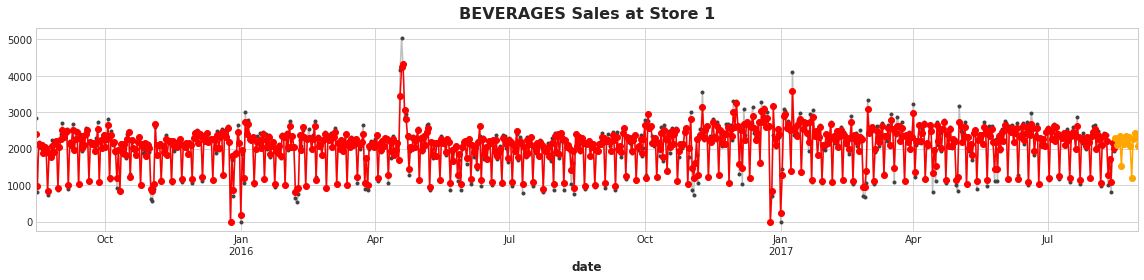

In [45]:
# see an example of predictions and forecast for a specific store/family:

STORE_NBR = '1'  # 1 - 54
FAMILY = 'BEVERAGES' # display(store_sales.index.get_level_values('family').unique())

ax = y.loc(axis=1)[STORE_NBR, FAMILY].plot(**plot_params, figsize=(16, 4))
ax = y_pred.loc(axis=1)[STORE_NBR, FAMILY].plot(ax=ax, marker='.', color='red', markersize=12) # markers: big size for tiny validation sets (1-2 days)
ax = test_pred_df.loc(axis=1)[STORE_NBR, FAMILY].plot(ax=ax, marker='.', color='orange', markersize=12)
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');

In [46]:
df_submit = pd.read_csv(comp_dir / 'sample_submission.csv', index_col='id')
df_submit.sales = test_pred.values
df_submit.to_csv('submission.csv', index=True)